In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import random
import cPickle as pickle
from matplotlib import ticker
%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

np.random.seed(1337)
import keras

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Plotting settings ###
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.linewidth']= 0.75
plt.rcParams['xtick.labelsize']= 5
plt.rcParams['ytick.labelsize']= 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.markerscale'] = 1
plt.rcParams['legend.fontsize'] = 4
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.edgecolor'] = 'black'

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


Using TensorFlow backend.


### Load training dataset to get the original scale of MRL value.

In [2]:
df1 = pd.read_pickle('varying_length_25to100_1.pkl')
# Get random sequences
df = df1[df1['set']=='random']
## Filter out UTRs with too few reads
df=df[df['total_reads']>=10]
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
# Split dataset into training and testing set
e_test = pd.DataFrame(columns=df.columns)
for i in range(25,101):
    tmp = df[df['len']==i]
    tmp.sort_values('total_reads', inplace=True, ascending=False)
    tmp.reset_index(inplace=True, drop=True)
    e_test = e_test.append(tmp.iloc[:100])
e_train = pd.concat([df, e_test, e_test]).drop_duplicates(keep=False)
# Load the training set MRL range into the scaler
scaler = preprocessing.StandardScaler()
scaler.fit(e_train['rl'].reshape(-1,1))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


StandardScaler(copy=True, with_mean=True, with_std=True)

In [3]:
# Load model
model = keras.models.load_model('Varying_length_25to100_model.hdf5')

## Sequence test using the model 

In [12]:
# Load 5' UTR sequence wt and variant here, pad Ns on 5' till 100 nt long if it's shorter.
wt = 'AGGCTGCGGCCAGCCGGGGCTGACTTGTTATGTTGGGCTCCGGAGGCCGTTAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTGGGCC'
v1 = 'AGGCTGCGGCCAGCCGGGGCTGACTTGTTACGTTGGGCTCCGGAGGCCGTTAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTGGGCC'

df = pd.DataFrame({'utr':[wt, v1], 'pred':[0, 0]})
test_seq = one_hot_encode(df=df, col='utr', seq_len=100)

predictions = model.predict(test_seq).reshape(-1)
df.loc[:,'pred'] = scaler.inverse_transform(predictions)
print df

       pred  \
0  4.673919   
1  5.795600   

                                                                                                   utr  
0  AGGCTGCGGCCAGCCGGGGCTGACTTGTTATGTTGGGCTCCGGAGGCCGTTAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTG...  
1  AGGCTGCGGCCAGCCGGGGCTGACTTGTTACGTTGGGCTCCGGAGGCCGTTAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTG...  


In [20]:
print 'The log 2 difference between wild type and variant on MRL is ' + str(np.log2(df['pred'] / df.loc[0,'pred'])[1])

The log 2 difference between wild type and variant on MRL is 0.31032515


## In silico saturation mutagenesis and model prediction of MRL change for all 5' UTR variants up to 100 nt. 

### Example of Gene ANKRD26

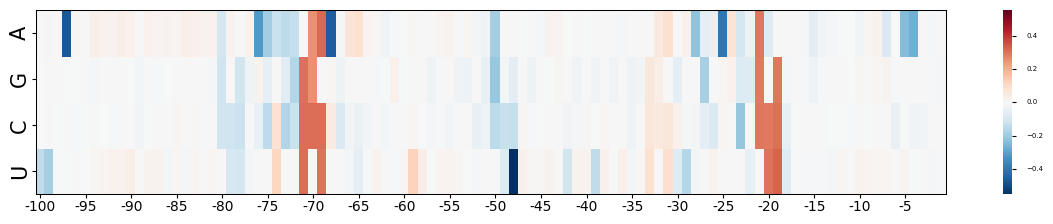

In [22]:
seq_list = []
# Load 5' UTR sequence here, pad Ns on 5' till 100 nt long if it's shorter.
wt = 'AGGCTGCGGCCAGCCGGGGCTGACTTGTTATGTTGGGCTCCGGAGGCCGTTAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTGGGCC'

seq_list.append(wt)
for i in range(len(wt)):
    for n in ['A', 'G', 'C', 'T']:
        seq_list.append(wt[:i] + n + wt[i+1:])

df = pd.DataFrame({'utr':seq_list, 'pred':[0 for x in range(len(seq_list))]})
test_seq = one_hot_encode(df=df, col='utr', seq_len=100)

predictions = model.predict(test_seq).reshape(-1)
df.loc[:,'pred'] = scaler.inverse_transform(predictions)

df['diff'] = np.log2(df['pred'] / df.loc[0,'pred'])
f, ax = plt.subplots()
f.set_size_inches((12,2.4))
vals = df.loc[1:,'diff'].values.reshape(100,4).T
ax = sns.heatmap(ax=ax, data=vals, cmap="RdBu_r", center=0)

ax.set_yticklabels(['A', 'G', 'C', 'U'][::-1], size=15)
xmajor_locator = ticker.MultipleLocator(5)
#ax.xaxis.set_major_locator(xmajor_locator)
ax.set_xticks(np.arange(0.5,100.5,5))
ax.set_xticklabels([str(x) for x in range(-100,0,5)], rotation=0,size = 10)

for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.tick_params(axis='both', pad=1);